In [1]:
import pickle
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
# from df_selector import *
from outliener import Outlier
from visualization import *

In [3]:

pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:

pd.set_option('display.max_columns', 100)

In [5]:
df = pd.read_csv("../data/user_overviewed_data.csv")
df.head()


Unnamed: 0               Bearer Id                Start  Start ms                  End  End ms  Dur. (ms)               IMSI  MSISDN/Number              IMEI     Last Location Name  Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  TCP DL Retrans. Vol (Bytes)  TCP UL Retrans. Vol (Bytes)  DL TP < 50 Kbps (%)  50 Kbps < DL TP < 250 Kbps (%)  250 Kbps < DL TP < 1 Mbps (%)  DL TP > 1 Mbps (%)  UL TP < 10 Kbps (%)  10 Kbps < UL TP < 50 Kbps (%)  50 Kbps < UL TP < 300 Kbps (%)  UL TP > 300 Kbps (%)  Activity Duration DL (ms)  Activity Duration UL (ms)   Dur. (ms).1 Handset Manufacturer                 Handset Type  Nb of sec with Vol DL < 6250B  Nb of sec with Vol UL < 1250B  Social Media DL (Bytes)  Social Media UL (Bytes)  Google DL (Bytes)  Google UL (Bytes)  Email DL (Bytes)  Email UL (Bytes)  Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)  Netflix UL (Bytes)  Gaming DL (Bytes)  Gaming UL (Bytes)  Other DL (Bytes)  Other UL (Bytes)  Total UL (Bytes)  Total DL (Bytes)  Social Media Data Volume (Bytes)  Google Data Volume (Bytes)  Email Data Volume (Bytes)  Youtube Data Volume (Bytes)  Netflix Data Volume (Bytes)  Gaming Data Volume (Bytes)  Other Data Volume (Bytes)  Total Data Volume (Bytes)
0           0 13114483460844900352.00  2019-04-04 12:01:00    770.00  2019-04-25 14:35:00  662.00 1823652.00 208201448079117.00 33664962239.00 35521209507511.00  9.16456699548519E+015            42.00             5.00                    23.00                    44.00                     19520.00                      7230.00               100.00                            0.00                           0.00                0.00               100.00                           0.00                            0.00                  0.00                   37624.00                   38787.00 1823652892.00              Samsung   Samsung Galaxy A5 Sm-A520F                         213.00                         214.00               1545765.00                 24420.00         1634479.00         1271433.00        3563542.00         137762.00         15854611.00          2501332.00          8198936.00          9656251.00       278082303.00        14344150.00      171744450.00        8814393.00       36749741.00      308879636.00                        1570185.00                  2905912.00                 3701304.00                  18355943.00                  17855187.00                292426453.00               180558843.00               345629377.00
1           1 13114483482878900224.00  2019-04-09 13:04:00    235.00  2019-04-25 08:15:00  606.00 1365104.00 208201909211140.00 33681854413.00 35794009006359.00                L77566A            65.00             5.00                    16.00                    26.00                     19520.00                      7230.00               100.00                            0.00                           0.00                0.00               100.00                           0.00                            0.00                  0.00                     168.00                    3560.00 1365104371.00              Samsung  Samsung Galaxy J5 (Sm-J530)                         971.00                        1022.00               1926113.00                  7165.00         3493924.00          920172.00         629046.00         308339.00         20247395.00         19111729.00         18338413.00         17227132.00       608750074.00         1170709.00      526904238.00       15055145.00       53800391.00      653384965.00                        1933278.00                  4414096.00                  937385.00                  39359124.00                  35565545.00                609920783.00               541959383.00               707185356.00
2           2 13114483484080500736.00  2019-04-09 17:42:00      1.00  2019-04-25 11:58:00  652.00 1361762.00 208200314458056.00 33760627129.00 35281510359387.00                D42335A            65.00             5.00         

In [6]:
df = df.drop("Unnamed: 0", axis=1)

## Task 3.1



Aggregate, per customer, the following information(treat missing & outliers by replacing by the mean or the mode of the corresponding variab

Average TCP retransmission
Average RTT
Handset type
Average throughput

In [7]:

user_experience_df = df[[
    'MSISDN/Number',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)',
    'Handset Type']].copy()
user_experience_df.head()

MSISDN/Number  Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  TCP DL Retrans. Vol (Bytes)  TCP UL Retrans. Vol (Bytes)                 Handset Type
0 33664962239.00            42.00             5.00                    23.00                    44.00                     19520.00                      7230.00   Samsung Galaxy A5 Sm-A520F
1 33681854413.00            65.00             5.00                    16.00                    26.00                     19520.00                      7230.00  Samsung Galaxy J5 (Sm-J530)
2 33760627129.00            65.00             5.00                     6.00                     9.00                     19520.00                      7230.00     Samsung Galaxy A8 (2018)
3 33750343200.00            65.00             5.00                    44.00                    44.00                     19520.00                      7230.00                      unknown
4 33699795932.00            65.00             5.00                     6.00                     9.00                     19520.00                      7230.00             Samsung Sm-G390F

In [8]:
# caluclate the totals
user_experience_df['Total Avg RTT (ms)'] = user_experience_df['Avg RTT DL (ms)'] + user_experience_df['Avg RTT UL (ms)']
user_experience_df['Total Avg Bearer TP (kbps)'] = user_experience_df['Avg Bearer TP DL (kbps)'] + user_experience_df['Avg Bearer TP UL (kbps)']
user_experience_df['Total TCP Retrans. Vol (Bytes)'] = user_experience_df['TCP DL Retrans. Vol (Bytes)'] + user_experience_df['TCP UL Retrans. Vol (Bytes)']
user_experience_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   MSISDN/Number                   146887 non-null  float64
 1   Avg RTT DL (ms)                 146887 non-null  float64
 2   Avg RTT UL (ms)                 146887 non-null  float64
 3   Avg Bearer TP DL (kbps)         146887 non-null  float64
 4   Avg Bearer TP UL (kbps)         146887 non-null  float64
 5   TCP DL Retrans. Vol (Bytes)     146887 non-null  float64
 6   TCP UL Retrans. Vol (Bytes)     146887 non-null  float64
 7   Handset Type                    146887 non-null  object 
 8   Total Avg RTT (ms)              146887 non-null  float64
 9   Total Avg Bearer TP (kbps)      146887 non-null  float64
 10  Total TCP Retrans. Vol (Bytes)  146887 non-null  float64
dtypes: float64(10), object(1)
memory usage: 12.3+ MB


In [9]:
user_experience_df.head()

MSISDN/Number  Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  TCP DL Retrans. Vol (Bytes)  TCP UL Retrans. Vol (Bytes)                 Handset Type  Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  Total TCP Retrans. Vol (Bytes)
0 33664962239.00            42.00             5.00                    23.00                    44.00                     19520.00                      7230.00   Samsung Galaxy A5 Sm-A520F               47.00                       67.00                        26750.00
1 33681854413.00            65.00             5.00                    16.00                    26.00                     19520.00                      7230.00  Samsung Galaxy J5 (Sm-J530)               70.00                       42.00                        26750.00
2 33760627129.00            65.00             5.00                     6.00                     9.00                     19520.00                      7230.00     Samsung Galaxy A8 (2018)               70.00                       15.00                        26750.00
3 33750343200.00            65.00             5.00                    44.00                    44.00                     19520.00                      7230.00                      unknown               70.00                       88.00                        26750.00
4 33699795932.00            65.00             5.00                     6.00                     9.00                     19520.00                      7230.00             Samsung Sm-G390F               70.00                       15.00                        26750.00

In [10]:
# aggregating user experience metrics per user
user_experience_df1 = user_experience_df.groupby(
    'MSISDN/Number').agg({
        'Total Avg RTT (ms)': 'sum',
        'Total Avg Bearer TP (kbps)': 'sum',
        'Total TCP Retrans. Vol (Bytes)': 'sum',
        'Handset Type': [lambda x: x.mode()[0]]})
user_experience_df1.head()

Total Avg RTT (ms) Total Avg Bearer TP (kbps) Total TCP Retrans. Vol (Bytes)                    Handset Type
                              sum                        sum                            sum                        <lambda>
MSISDN/Number                                                                                                              
33601001722.00              46.00                      76.00                     2895381.00  Huawei P20 Lite Huawei Nova 3E
33601001754.00              31.00                      99.00                     9272453.00          Apple iPhone 7 (A1778)
33601002511.00              59.00                      97.00                     4150403.00                         unknown
33601007832.00              84.00                     248.00                        2396.00         Apple iPhone 5S (A1457)
33601008617.00             119.00                   56844.00                     9738882.00         Apple iPhone Se (A1723)

In [11]:
user_experience_df = pd.DataFrame(columns=[
    "Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)",
    "Handset Type"])

user_experience_df["Total Avg RTT (ms)"] = user_experience_df1["Total Avg RTT (ms)"]['sum']
user_experience_df["Total Avg Bearer TP (kbps)"] = user_experience_df1["Total Avg Bearer TP (kbps)"]['sum']
user_experience_df["Total TCP Retrans. Vol (Bytes)"] = user_experience_df1["Total TCP Retrans. Vol (Bytes)"]['sum']
user_experience_df["Handset Type"] = user_experience_df1["Handset Type"]['<lambda>']
user_experience_df.head()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  Total TCP Retrans. Vol (Bytes)                    Handset Type
MSISDN/Number                                                                                                                 
33601001722.00               46.00                       76.00                      2895381.00  Huawei P20 Lite Huawei Nova 3E
33601001754.00               31.00                       99.00                      9272453.00          Apple iPhone 7 (A1778)
33601002511.00               59.00                       97.00                      4150403.00                         unknown
33601007832.00               84.00                      248.00                         2396.00         Apple iPhone 5S (A1457)
33601008617.00              119.00                    56844.00                      9738882.00         Apple iPhone Se (A1723)

### Compute & list 10 of the top, bottom, most frequent

#### top 10 RTT values in the dataset

In [12]:
# top 10 rtt values in the dataset

rtt = user_experience_df.sort_values('Total Avg RTT (ms)', ascending=False)
top_10_rtt = rtt.head(10)['Total Avg RTT (ms)']
bottom_10_rtt = rtt.tail(10)['Total Avg RTT (ms)']
most_10_rtt = user_experience_df['Total Avg RTT (ms)'].value_counts().head(10)


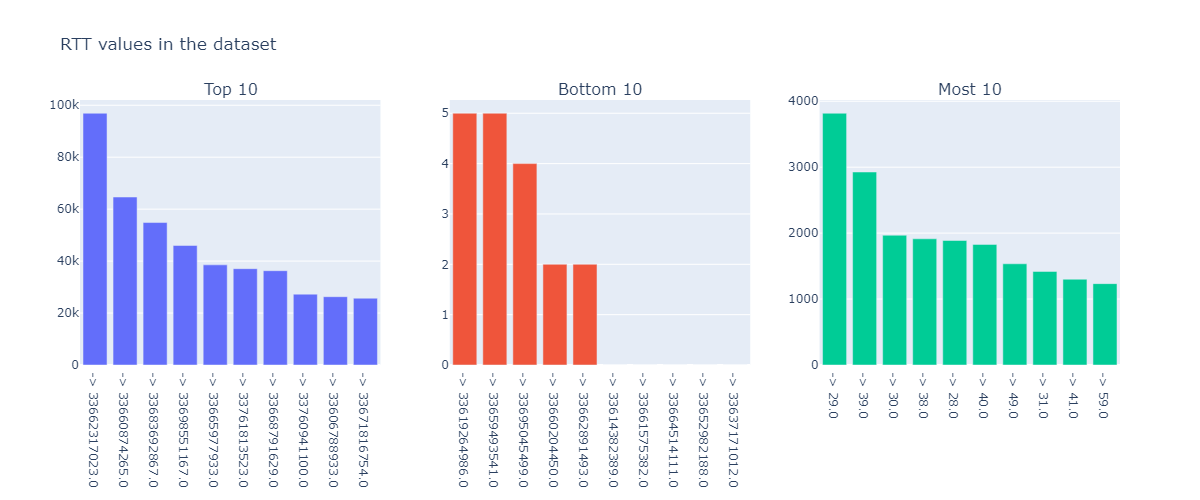

In [13]:
mult_hist([top_10_rtt, bottom_10_rtt, most_10_rtt], 1, 3,
    "RTT values in the dataset", ['Top 10', 'Bottom 10', 'Most 10'])

#### Top 10 tcp values in the dataset

In [14]:
# top 10 tcp values in the dataset

tcp = user_experience_df.sort_values('Total TCP Retrans. Vol (Bytes)', ascending=False)
tcp_10_tcp = tcp.head(10)['Total TCP Retrans. Vol (Bytes)']
bottom_10_tcp = tcp.tail(10)['Total TCP Retrans. Vol (Bytes)']
most_10_tcp = user_experience_df['Total TCP Retrans. Vol (Bytes)'].value_counts().head(10)

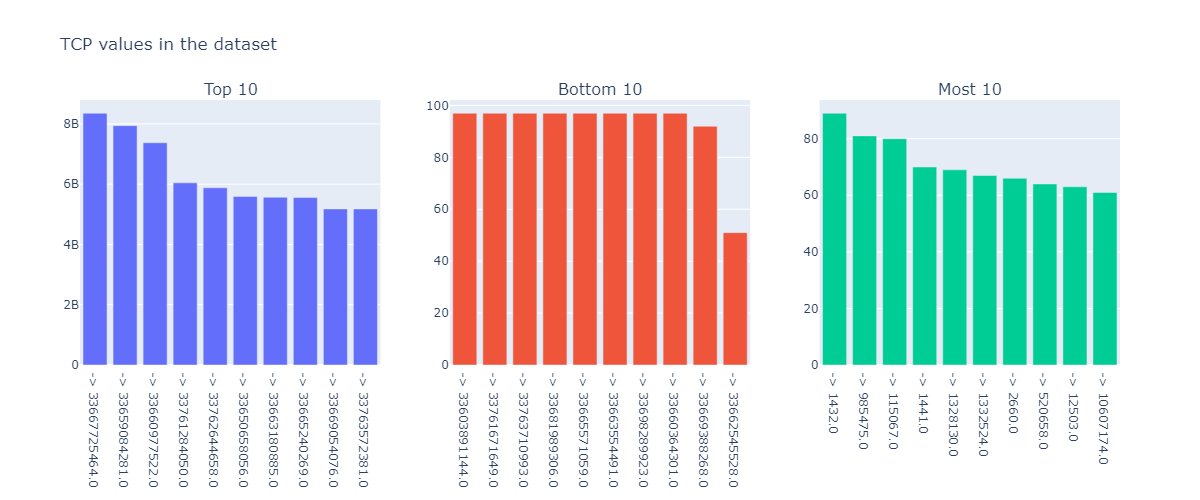

In [15]:
mult_hist([tcp_10_tcp, bottom_10_tcp, most_10_tcp], 1, 3,
    "TCP values in the dataset", ['Top 10', 'Bottom 10', 'Most 10'])

### Throughput values in the dataset.


In [16]:
sorted_by_tp = user_experience_df.sort_values(
    'Total Avg Bearer TP (kbps)', ascending=False)
top_10 = sorted_by_tp.head(10)['Total Avg Bearer TP (kbps)']
last_10 = sorted_by_tp.tail(10)['Total Avg Bearer TP (kbps)']
most_10 = user_experience_df['Total Avg Bearer TP (kbps)'].value_counts().head(10)

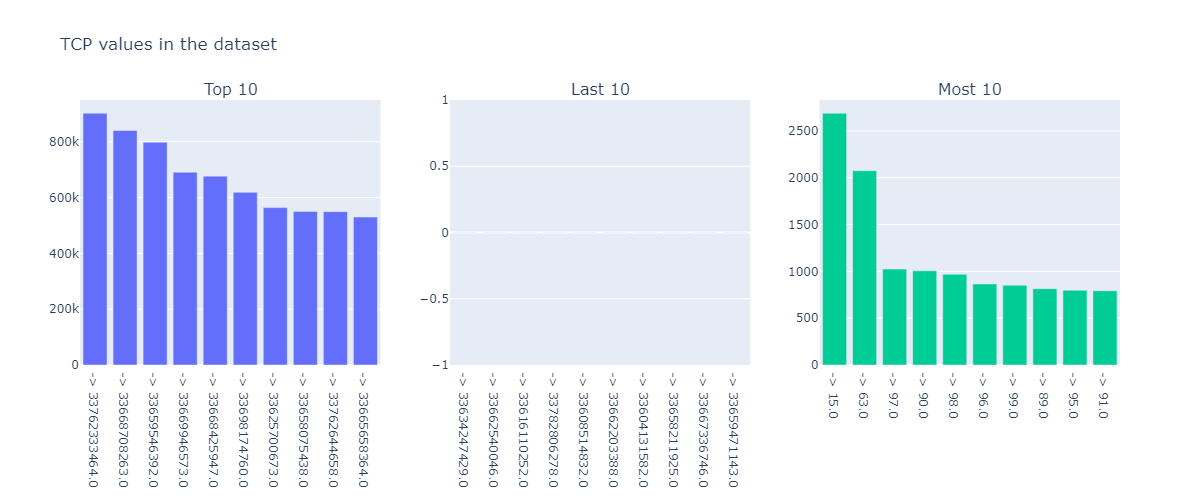

In [17]:
mult_hist([top_10, last_10, most_10, top_10], 1,
          3, "TCP values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

### The distribution of the average throughput  per handset type and provide interpretation for your findings.

In [18]:
user_experience_df.head()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  Total TCP Retrans. Vol (Bytes)                    Handset Type
MSISDN/Number                                                                                                                 
33601001722.00               46.00                       76.00                      2895381.00  Huawei P20 Lite Huawei Nova 3E
33601001754.00               31.00                       99.00                      9272453.00          Apple iPhone 7 (A1778)
33601002511.00               59.00                       97.00                      4150403.00                         unknown
33601007832.00               84.00                      248.00                         2396.00         Apple iPhone 5S (A1457)
33601008617.00              119.00                    56844.00                      9738882.00         Apple iPhone Se (A1723)

In [32]:
handset_type_df = user_experience_df.groupby('Handset Type').agg({
    "Total Avg Bearer TP (kbps)":"mean","Total TCP Retrans. Vol (Bytes)":"mean"
})
handset_type_df.head()

Total Avg Bearer TP (kbps)  Total TCP Retrans. Vol (Bytes)
Handset Type                                                                                 
A-Link Telecom I. Cubot A5                           23510.00                      9541170.00
A-Link Telecom I. Cubot Note Plus                     6699.00                       616213.00
A-Link Telecom I. Cubot Note S                        8937.00                     41411731.00
A-Link Telecom I. Cubot Nova                         56217.00                       137170.00
A-Link Telecom I. Cubot Power                        69468.00                         8041.00

In [33]:
# sorting per tp
tp_sorted = handset_type_df.sort_values(
    'Total Avg Bearer TP (kbps)', ascending=False)
top_tp = tp_sorted['Total Avg Bearer TP (kbps)']



In [43]:
top_tp.head(10)

Handset Type
Spa Condor Elect. Allure M2          168623.00
Huawei Par-Lx9                       144115.00
Huawei B715S-23C                     141692.50
Asustek Wireless-Ac1200 Lte Router   125525.00
New-Bund Technol. Thor               113444.50
New-Bund Technol. Mix 2              105211.00
Lg G6+                               100135.00
Zyxel Communicat. Sbg3600             97351.00
Huawei Y9 2019                        91739.00
Xiaomi Communica. M1902F1G            85613.67
Name: Total Avg Bearer TP (kbps), dtype: float64

In [45]:
hist(top_tp)

In [46]:
# sorting per tcp
tcp_sorted = handset_type_df.sort_values(
    'Total TCP Retrans. Vol (Bytes)', ascending=False)
top_tcp =tcp_sorted['Total TCP Retrans. Vol (Bytes)']


In [47]:
top_tcp

Handset Type
Simcom Wireless. Sim800H           4344115651.00
Lg Lg-H635                          904873011.00
Sfr Star Trail 5 By Sfr             432474957.00
Huawei Bln-Al10                     329174592.00
Mikrotikls Sia R11E-Lte             321688480.00
                                        ...     
Gotron (Hk) Elec. Armor X                1500.00
Nokia Lumia 630 Dual Sim Rm-978          1422.00
Samsung Gt-B5510                         1344.00
Samsung Galaxy Note 8 (Sm-N9500)          418.00
Casper Bilgisaya. Via M1                  360.00
Name: Total TCP Retrans. Vol (Bytes), Length: 1363, dtype: float64

In [49]:
hist(top_tcp.head(10))

#### checking the Outlier


In [50]:
user_metric_df = user_experience_df[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]]

<AxesSubplot:>

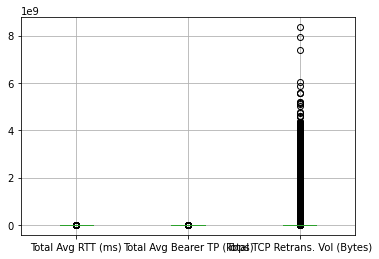

In [51]:
outlier_handler = Outlier(user_metric_df)
user_metric_df.boxplot()

In [52]:
outlier_handler.getOverview()

Q1    median         Q3        IQR  skew  number_of_outliers percentage_of_outliers  min_value     max_value        mean       lower       upper
label                                                                                                                                                                                
Total Avg RTT (ms)                39.00     65.00     126.00      87.00 53.74               11909                 11.27%       0.00      96924.00      163.34      -91.50      256.50
Total Avg Bearer TP (kbps)        97.00    302.00   26790.25   26693.25  3.96               10456                  9.89%       0.00     902222.00    21130.82   -39942.88    66830.12
Total TCP Retrans. Vol (Bytes) 83894.25 763893.00 4916588.50 4832694.25 15.01               15405                 14.57%      51.00 8354209105.00 26699585.54 -7165147.12 12165629.88

In [53]:
outlier_handler.replace_outliers_with_iqr(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

c:\Users\Samrit\Desktop\10 academy projects\TelecomUpdate\Telecommunication-Data-Analysis\scripts\outliener.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\Samrit\Desktop\10 academy projects\TelecomUpdate\Telecommunication-Data-Analysis\scripts\outliener.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
outlier_handler.getOverview()

Q1    median         Q3        IQR  skew  number_of_outliers percentage_of_outliers  min_value   max_value       mean       lower       upper
label                                                                                                                                                                             
Total Avg RTT (ms)                39.00     65.00     126.00      87.00  1.14                   0                   0.0%       0.00      256.50      95.85      -91.50      256.50
Total Avg Bearer TP (kbps)        97.00    302.00   26790.25   26693.25  1.27                   0                   0.0%       0.00    66830.12   15639.81   -39942.88    66830.12
Total TCP Retrans. Vol (Bytes) 83894.25 763893.00 4916588.50 4832694.25  1.21                   0                   0.0%      51.00 12165629.88 3236741.07 -7165147.12 12165629.88

<AxesSubplot:>

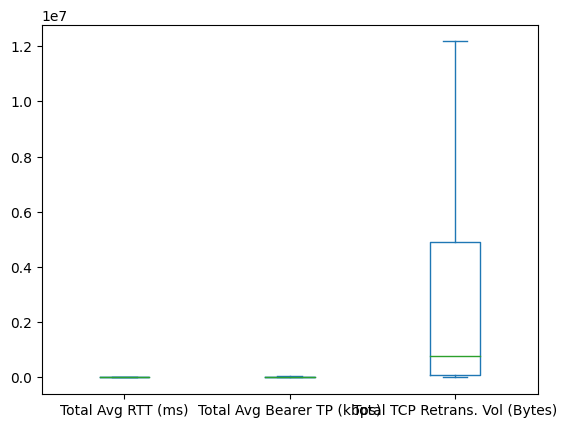

In [55]:
user_metric_df.plot.box()

##### K-means Clustering


In [56]:
# scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_metric_df)
scaled_data

array([[-0.66348121, -0.66553306, -0.07718727],
       [-0.86313599, -0.66454954,  1.36477629],
       [-0.49044707, -0.66463506,  0.20659437],
       ...,
       [-0.5836193 , -0.22555909, -0.68257811],
       [-0.74334312, -0.66382259, -0.67580862],
       [-0.47713675, -0.66737181, -0.70461297]])

In [57]:
normalized_data = normalize(scaled_data)
normalized_data

array([[-0.70364476, -0.70582082, -0.08185977],
       [-0.49429148, -0.38056712,  0.78156548],
       [-0.57601703, -0.78059619,  0.24263959],
       ...,
       [-0.63028589, -0.24359494, -0.73715751],
       [-0.61732633, -0.55128669, -0.56124076],
       [-0.44120283, -0.61711098, -0.65154746]])

In [58]:
kmeans = KMeans(n_clusters=3, random_state=1).fit(normalized_data)
kmeans.labels_

array([0, 2, 0, ..., 0, 0, 0])

In [59]:
user_metric_df.insert(0, 'cluster', kmeans.labels_)
user_metric_df

cluster  Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  Total TCP Retrans. Vol (Bytes)
MSISDN/Number                                                                                              
33601001722.00            0               46.00                       76.00                      2895381.00
33601001754.00            2               31.00                       99.00                      9272453.00
33601002511.00            0               59.00                       97.00                      4150403.00
33601007832.00            0               84.00                      248.00                         2396.00
33601008617.00            1              119.00                    56844.00                      9738882.00
...                     ...                 ...                         ...                             ...
33789967113.00            0               53.00                       67.00                        56578.00
33789980299.00            1              109.00                    66830.12                     10617270.00
33789996170.00            0               52.00                    10365.00                       218045.00
33789997247.00            0               40.00                      116.00                       247983.00
337000037000919.00        0               60.00                       33.00                       120596.00

[105716 rows x 4 columns]

In [60]:

user_metric_df['cluster'].value_counts()

0    51371
1    36837
2    17508
Name: cluster, dtype: int64

In [61]:
fig = px.scatter(user_metric_df, x='Total TCP Retrans. Vol (Bytes)', y='Total Avg Bearer TP (kbps)',
                 color='cluster', size='Total Avg RTT (ms)')
fig.show()

In [63]:
cluster0 = user_metric_df[user_metric_df["cluster"]==0]
cluster0[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  Total TCP Retrans. Vol (Bytes)
count            51371.00                    51371.00                        51371.00
mean                51.90                     2439.14                       615374.22
std                 26.28                     5922.83                       954636.09
min                  0.00                        0.00                           51.00
25%                 32.00                       84.00                        26750.00
50%                 45.00                      109.00                       151663.00
75%                 64.00                      404.00                       763893.00
max                154.00                    35574.00                      4766930.00

In [64]:
cluster1 = user_metric_df[user_metric_df["cluster"]==1]
cluster1[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  Total TCP Retrans. Vol (Bytes)
count            36837.00                    36837.00                        36837.00
mean               162.95                    38617.64                      3597501.03
std                 78.85                    25085.80                      4322597.76
min                 19.00                        0.00                          169.00
25%                 89.00                    14743.00                       266240.00
50%                159.00                    41198.00                      1528277.00
75%                256.50                    66830.12                      5491947.00
max                256.50                    66830.12                     12165629.88

In [65]:
cluster2 = user_metric_df[user_metric_df["cluster"]==2]
cluster2[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  Total TCP Retrans. Vol (Bytes)
count            17508.00                    17508.00                        17508.00
mean                83.61                     6026.87                     10169167.52
std                 60.72                    12674.25                      2759851.02
min                  0.00                        0.00                      3005649.00
25%                 39.00                       93.00                      7764034.75
50%                 65.00                      141.00                     12165629.88
75%                109.00                     2370.75                     12165629.88
max                256.50                    66830.12                     12165629.88

### Saving Data

In [ ]:
# save the dataframe
user_experience_df.to_csv('../data/user_experience_data.csv')

In [ ]:
# save the clustering model
with open("../models/user_experience.pkl", "wb") as f:
    pickle.dump(kmeans, f)